# Read in data and set up plotting

In [287]:
import pandas as pd
import numpy as np
import ast
from sentence_transformers import SentenceTransformer
from mlxtend.evaluate import permutation_test
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, cdist
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import permutation
import random
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from numpy import std, mean, sqrt
import itertools
import networkx as nx
from numpy.random import permutation
import os
import random
from mlxtend.evaluate import permutation_test as ml_permutation_test
import pickle 

# Set seed to my birthday (04/16) for all projects for consistency and reproducibility
random.seed(416)
np.random.seed(416)


def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
            "#826AED",  # Medium slate blue
            "#00A896",  # Persian green
            "#D41876",  # Telemagenta
            "#89DAFF",  # Pale azure
            "#F7B2AD",  # Melon
            "#342E37",  # Dark grayish-purple
            "#7DCD85",  # Emerald
            "#E87461",  # Medium-bright orange
            "#E3B505",  # Saffron
            "#2C3531",  # Dark charcoal gray with a green undertone
            "#D4B2D8",  # Pink lavender
            "#7E6551",  # Coyote
            "#F45B69",  # Vibrant pinkish-red
            "#020887",  # Phthalo Blue
            "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True


make_aesthetic()


def clean_condition_col(x):
    if x == "f_l":
        return "LowExposure\nLabeled"
    elif x == "f_u":
        return "LowExposure\nUnlabeled"
    elif x == "m_l":
        return "HiExposure\nLabeled"
    elif x == "m_u":
        return "HiExposure\nUnlabeled"
    elif x == "h":
        return "HumanControl"


df = pd.read_csv("../../data/experiment_data/data_clean_with_elab.csv")
df['init_array'] = df['init_array'].apply(lambda x: eval(x)
                                          if isinstance(x, str) else x)
df['clean_condition'] = df['condition'].apply(lambda x: clean_condition_col(x))
df.head()

,Unnamed: 0,response_id,participant_id,response_text,response_date,condition,condition_order,item,response_chain,init_array,...,idea6_txt,idea_minus_excluded6_txt,source,trial_no,trial_no_excluded,elab_ibf,elab_ipf,elab_not_sw,elab_n_tokens,clean_condition
0,0,da90af9c-e2e7-4309-9ff0-3f7067b7a6a7,0b53acd4-eef9-4cc9-89b4-d041c93a8474,sock dispenser,2023-07-14 01:11:16,h,0,shoe,3,"[f580f114-af7e-4d8e-8b0f-b8721ad441de, d8f156b...",...,Knee pads,Knee pads,Creative Mornings newsletter,13,12.0,2.651837,7.288467,2,2,HumanControl
1,1,1fdfaed9-f4db-435f-940d-470b12cfcaee,c077bfaf-e624-4110-8212-dda6b23dc188,shoe as something used to play a game,2023-07-14 02:01:00,h,0,shoe,3,"[85eae1c0-b64f-406d-aae1-ce5f5db8a6c3, f580f11...",...,"a house for a little old lady and her wee, tin...","a house for a little old lady and her wee, tin...",Creative Mornings newsletter,16,15.0,2.918359,9.136040,3,8,HumanControl
2,2,5b3c4540-464f-4266-86e0-94e4d40bee18,27419286-9691-47b0-aa2c-d78eecdb5794,Attach shoe to wall and use the laces to hang ...,2023-07-14 01:13:22,h,0,shoe,3,"[dd3c538d-f5a4-4b53-b5f7-d37d679e8053, d8f156b...",...,Knee pads,Knee pads,Creative Mornings newsletter,14,13.0,6.161908,17.942674,7,12,HumanControl
3,3,4f4f3050-e47b-440f-8a46-64ed6ff76d42,4d682a85-5150-4231-829d-0c8bc9a0267b,home for plants,2023-07-14 02:44:52,h,0,shoe,3,"[5b3c4540-464f-4266-86e0-94e4d40bee18, 2f4bf01...",...,shoe as something used to play a game,shoe as something used to play a game,Creative Mornings newsletter,18,17.0,1.149419,3.735428,2,3,HumanControl
4,4,64c1edb9-b90d-4d62-ada3-642dc9bb1551,79a6c59e-9eb8-4602-ac28-330a88463401,Place it near a backyard door and use it to ho...,2023-07-14 03:10:38,h,0,shoe,3,"[ffdbf261-99a2-4e8e-9ab7-9bfe41c171f2, 4f4f305...",...,Attach shoe to wall and use the laces to hang ...,Attach shoe to wall and use the laces to hang ...,Creative Mornings newsletter,19,18.0,6.185689,18.360093,9,14,HumanControl


# Get embeding of all ideas

The goal is to get a hash map `idea2vec` where key is text and value is sbert vector

In [288]:
def get_idea2vec(tdf):
    idea2vec_fn = "idea2vec.pickle"
    if not os.path.exists(idea2vec_fn):
        model = SentenceTransformer('all-MiniLM-L12-v2')

        # Get a list of all ideas
        example_cols = [x for x in tdf.columns if "_txt" in x and "excluded" not in x]
        tdf['init_array_list'] = tdf[example_cols].values.tolist()
        all_ideas = []
        all_ideas.extend(tdf['response_text'])
        for x in example_cols:
            all_ideas.extend(tdf[x].to_list())
        all_ideas = list(set(all_ideas))

        # Get embeddings and create idea2vec mapping --> save to pickle
        embeddings = model.encode(all_ideas)
        idea2vec = dict(zip(all_ideas, embeddings))
        with open('idea2vec.pickle', 'wb') as f:
            pickle.dump(idea2vec, f)
        return tdf, idea2vec
    else:
        example_cols = [x for x in tdf.columns if "_txt" in x and "excluded" not in x]
        tdf['init_array_list'] = tdf[example_cols].values.tolist()
        with open('idea2vec.pickle', 'rb') as f:
            idea2vec = pickle.load(f)
        return tdf, idea2vec
df, idea2vec = get_idea2vec(df)

# Defune functions for inferential statistics



- We will first do a Kruskal Wallis test to see if the `dv` differs by `condition`. This is a non-parametric equivalent to ANOVA. If the dv differs by condition, we follow up with...

- Permutation tests on the difference in means with an fdr correction for multiple comparisons. I chose this analysis strategy because this stuff is weirdly distributed

- Do I do median or means actually?

In [289]:
def process_metrics(mydf, grouping_var=None, plot_type='point', num_perm=10*1000):
    """
    Process the metrics for a dataframe. This handles all the analysis. When fed a dataframe it looks for columns containing
    `sim` or `dist` and analyzes them. _
    
    Foreach distance or similarity dv:
    
    1. Conduct a Kurskal Wallis test (akin to non-parametric ANOVA) to see if `dv` differs by condition. 
    2. Plot the distribution of `dv` by condition
    3. Conduct pairwise permutation tests (testing for a difference in means) and apply an FDR adjustment to p-values
    
    Params
    - mydf: The dataframe
    - how ('boot', 'perm'): Either conduct a permutation test or feed in an already bootstrapped df 
    - paired (bool): Whether permutation test is on paired data
    - plot_type ('box', 'swarm', 'strip', 'bar', 'line', 'point'): Tye of plot
    """
    dist_metrics = [x for x in mydf.columns if "sim" in x or "dist" in x]
    print(dist_metrics)
    for dv in dist_metrics:
        plt.show()
        kruskal_wallis(mydf, "clean_condition", dv)
        display(pairwise_tests(mydf, "clean_condition", dv, grouping_var, num_perm))
        plot_distributions(mydf, "clean_condition", dv, plot_type)


def plot_distributions(tdf, group_col, data_col, plot_type):
    # We have many graphs, need to have each condition mapped to consistent color
    # Let's make it so unlabeled is a lighter shade of labeled

    if data_col.startswith("ai"):
        tdf = tdf.query("condition != 'h'")
    else:
        pass

    if plot_type == "box":
        graph_func = sns.boxplot
    elif plot_type == "swarm":
        graph_func = sns.swarmplot
    elif plot_type == "strip":
        graph_func = sns.stripplot
    elif plot_type == 'bar':
        graph_func = sns.barplot
    elif plot_type == "line":
        graph_func = sns.lineplot
    elif plot_type == "point":
        graph_func = sns.pointplot
    else:
        raise ValueError(f"Unknown plot_type: {plot_type}")

    color_dict = {
        'LowExposure\nLabeled': '#388659',
        'LowExposure\nUnlabeled': '#7EC99D',
        'HumanControl': '#D41876',
        'HiExposure\nLabeled': '#826AED',
        'HiExposure\nUnlabeled': '#D1C8F9',
    }
    order = tdf.groupby(group_col)[data_col].mean().sort_values().index
    plt.figure(figsize=(14, 8))
    graph_func(data=tdf,
               x=group_col,
               y=data_col,
               order=order,
               palette=color_dict,
               errorbar=('ci', 95))
    plt.title(f"{data_col} by condition")
    plt.show()


def kruskal_wallis(tdf, group_col, data_col):
    """Kurskal Wallis test for non-parametric group differences"""
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
    H, p = stats.kruskal(
        *[group[data_col].values for name, group in tdf.groupby(group_col)])
    if p < 0.05:
        print(
            f"We conducted a Kruskal Wallis test and found {data_col} differed by {group_col}, H={np.round(H, 2)}, p={p}"
        )
    else:
        print(
            f"We conducted a Kruskal Wallis test and found {data_col} DID NOT DIFFER by {group_col}, H={np.round(H, 2)}, p={p}"
        )
    return H, p


def pairwise_tests(tdf,
                   group_col,
                   data_col,
                   grouping_var=None,
                   num_permutations=10*1000):
    """Concducts pairwise permutation tests with FDR correction"""
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
    groups = tdf[group_col].unique()
    group_pairs = list(itertools.combinations(groups, 2))
    results = []

    for group1, group2 in group_pairs:
        group1_data = tdf[tdf[group_col] == group1][data_col]
        group2_data = tdf[tdf[group_col] == group2][data_col]

        p = pandas_perm_test(tdf, group_col, group1, group2, data_col,grouping_var, num_permutations)

        mean_diff = np.mean(group1_data) - np.mean(group2_data)
        pooled_sd = sqrt((group1_data.std()**2 + group2_data.std()**2) / 2)
        ef_size = mean_diff / pooled_sd
        results.append([group1, group2, mean_diff, ef_size, p])

    results_df = pd.DataFrame(
        results,
        columns=['group1', 'group2', 'Diff in Means', "Cohen's d", 'p'])
    reject, pvals_corrected, _, _ = multipletests(results_df['p'],
                                                  method='fdr_bh')
    results_df['p_adj'] = pvals_corrected
    results_df['Reject Null'] = results_df['p_adj'].apply(
        lambda x: 'YES' if x < 0.05 else 'NO')
    return results_df


def pandas_perm_test(df, 
                     iv, 
                     iv_val1, 
                     iv_val2, 
                     dv, 
                     group_vars=None,
                     n=500, 
                     test_statistic=None, 
                     random_seed=416):
    """
    Performs a permutation test on the given DataFrame. 
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        iv (str): The independent variable (column name in df).
        iv_val1 (str): The first value of the independent variable.
        iv_val2 (str): The second value of the independent variable.
        dv (str): The dependent variable (column name in df).
        group_vars (list[str], optional): List of variables to group by before permuting. Defaults to None.
        n (int, optional): The number of permutations to perform. Defaults to 500.
        test_statistic (callable, optional): Function to compute the test statistic. 
                                             Should take two arrays and return a float. 
                                             Defaults to difference in means.
        random_seed (int, optional): Seed for the random number generator. Defaults to 416.
    
    Returns:
        float: The p-value of the permutation test.
        
    Example:
        p_value = pandas_perm_test(df, iv='condition', iv_val1='treatment', iv_val2='control', dv='response', group_vars= ['participant', 'trial_no'])
    """
    np.random.seed(random_seed)

    if test_statistic is None:
        test_statistic = lambda x, y: abs(np.mean(x) - np.mean(y))

    perm_df = df.copy()
    
    # Filter the data only once
    data1 = perm_df[perm_df[iv] == iv_val1][dv].values
    data2 = perm_df[perm_df[iv] == iv_val2][dv].values

    observed_statistic = test_statistic(data1, data2)
    permuted_statistics = np.zeros(n)
    
    if group_vars is not None:
        for i in range(n):
            perm_df[iv] = perm_df.groupby(group_vars)[iv].transform(np.random.permutation)
            perm_data1 = perm_df[perm_df[iv] == iv_val1][dv].values
            perm_data2 = perm_df[perm_df[iv] == iv_val2][dv].values
            permuted_statistics[i] = test_statistic(perm_data1, perm_data2)
    else:
        combined_data = np.concatenate((data1, data2))
        for i in range(n):
            np.random.shuffle(combined_data)
            perm_data1 = combined_data[:len(data1)]
            perm_data2 = combined_data[len(data1):]
            permuted_statistics[i] = test_statistic(perm_data1, perm_data2)
    
    p_value = (np.sum(permuted_statistics >= observed_statistic) + 1) / (n+1)
    return p_value

def perm_test_simple(x, y, num_permutations, paired=False, seed=416):
    p_value = ml_permutation_test(x,
                                  y,
                                  method='approximate',
                                  seed=seed,
                                  num_rounds=num_permutations)
    return p_value


def abs_diff_in_means(group1, group2):
    return abs(group1.mean() - group2.mean())

# LOCAL DIVERSITY 
Here, we look at the diversity of idea sets on a `local` level -- at the level of each trial. 

What is the story so far (July 30)? 

FINDING 1
- AI exposure shapes human thought. When we show many AI ideas, participant ideas become closer to the centroid of these ideas than when we only show few AI ideas. This AI influence comes at the cost of human-ness: High exposure caused high similarity between participant and AI ideas, but LOWER similarity between participant ideas and human examples. This suggest that 
as the prevalence of AI ideas increase, human ideas may drift towards those of AI. 

FINDING 2
- We then wondered: How would exposure shape the diversity of ideas? As described above, participant ideas become more similar to AI ideas as we increased AI exposure. We found that the effect of exposure on diversity of ideas was non-linear: Low exposure yielded the highest number of distinct concepts per condition, followed by high exposure, then no exposure. Overall, then, we find evidence that counters popular fears of algorithmic homogonization: On average, AI exposure increases the diversity of thought. But diversity is maximized when there is low rather than high exposure.

## Compute/analyze local diversity metrics

['cent_dist', 'max_sim', 'max_dist', 'human_cent_dist', 'ai_cent_dist', 'ai_human_ratio_sim', 'ai_max_sim']
We conducted a Kruskal Wallis test and found cent_dist differed by clean_condition, H=23.64, p=9.425851237104829e-05


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,-0.000524,-0.004511,0.929607,0.929607,NO
1,HumanControl,LowExposure\nUnlabeled,-0.003625,-0.031085,0.551945,0.676155,NO
2,HumanControl,HiExposure\nLabeled,-0.022799,-0.191559,0.000700,0.003500,YES
3,HumanControl,HiExposure\nUnlabeled,-0.018268,-0.150328,0.004800,0.011999,YES
4,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.003101,-0.027466,0.608539,0.676155,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,-0.022275,-0.193075,0.000600,0.003500,YES
6,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.017743,-0.150437,0.005999,0.011999,YES
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.019174,-0.165663,0.002000,0.006666,YES
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.014643,-0.123764,0.021798,0.036330,YES
9,HiExposure\nLabeled,HiExposure\nUnlabeled,0.004532,0.037550,0.490151,0.676155,NO


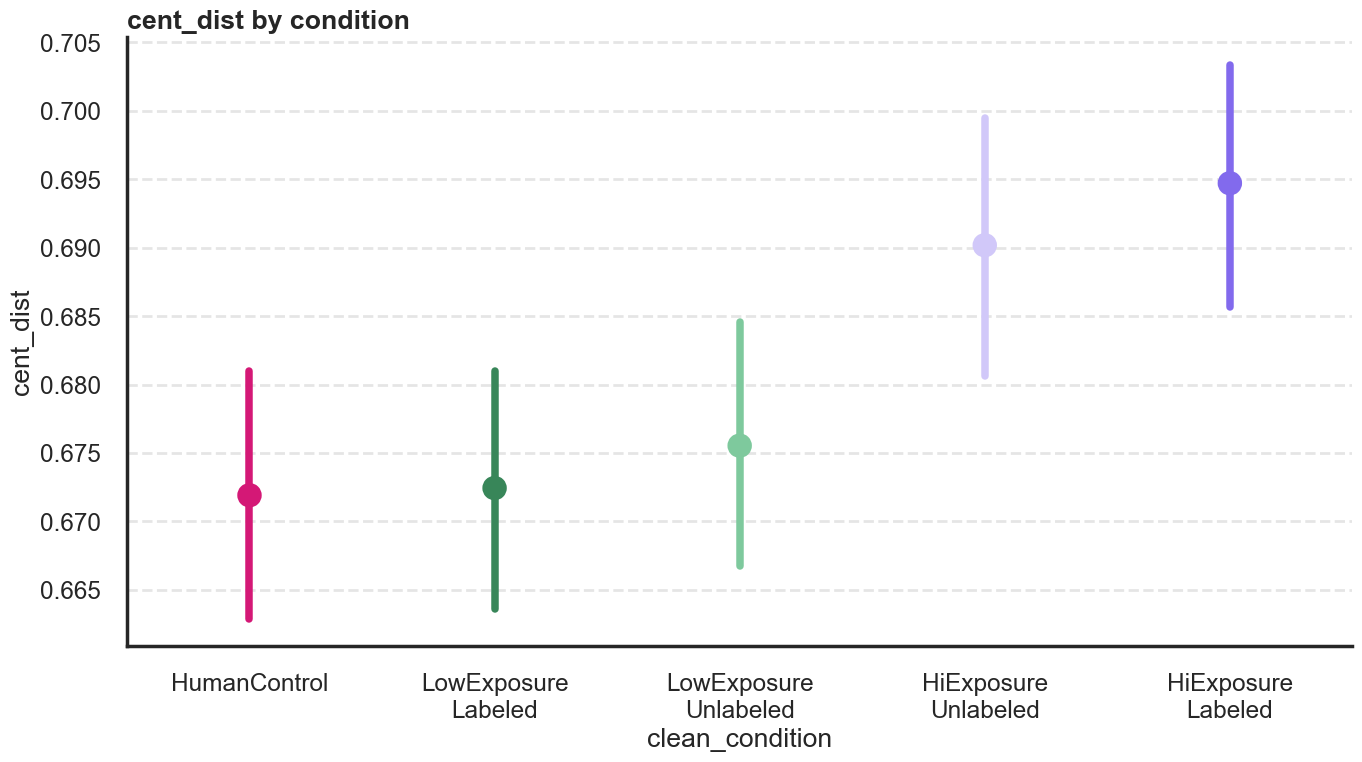

We conducted a Kruskal Wallis test and found max_sim DID NOT DIFFER by clean_condition, H=5.24, p=0.2637253255944813


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,-0.006689,-0.057900,0.285271,0.614314,NO
1,HumanControl,LowExposure\nUnlabeled,-0.004246,-0.037064,0.485651,0.614314,NO
2,HumanControl,HiExposure\nLabeled,0.005716,0.049156,0.364264,0.614314,NO
3,HumanControl,HiExposure\nUnlabeled,0.001232,0.010349,0.845315,0.845315,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,0.002444,0.021396,0.689931,0.766590,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,0.012406,0.106974,0.047895,0.478952,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.007921,0.066727,0.213579,0.614314,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,0.009962,0.086635,0.105389,0.526947,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.005477,0.046516,0.389461,0.614314,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.004485,-0.037545,0.491451,0.614314,NO


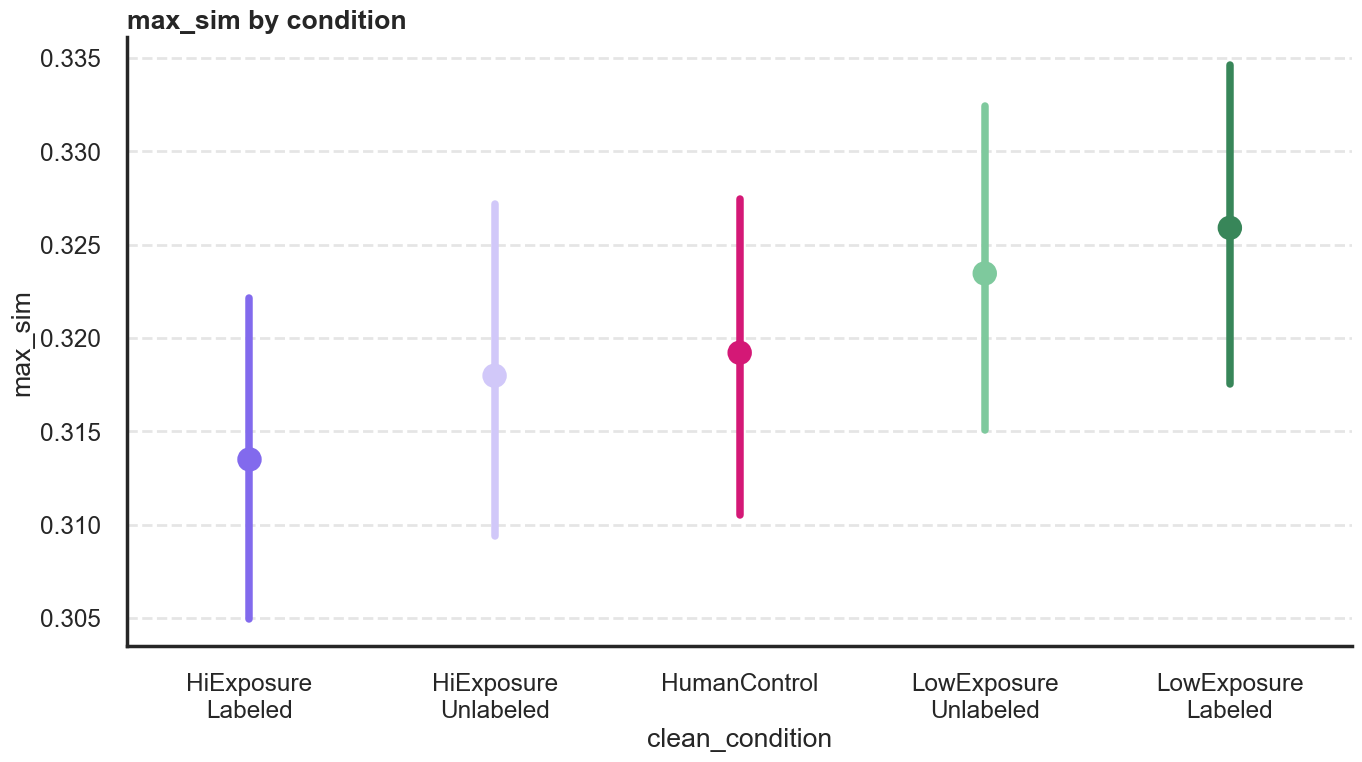

We conducted a Kruskal Wallis test and found max_dist DID NOT DIFFER by clean_condition, H=4.88, p=0.29982335862306125


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,0.003202,0.050967,0.336766,0.481095,NO
1,HumanControl,LowExposure\nUnlabeled,0.002447,0.038076,0.484252,0.605314,NO
2,HumanControl,HiExposure\nLabeled,0.007534,0.112921,0.037096,0.191481,NO
3,HumanControl,HiExposure\nUnlabeled,0.007294,0.110321,0.038296,0.191481,NO
4,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.000755,-0.012121,0.823318,0.914797,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,0.004332,0.066829,0.217978,0.392461,NO
6,LowExposure\nLabeled,HiExposure\nUnlabeled,0.004093,0.063742,0.235476,0.392461,NO
7,LowExposure\nUnlabeled,HiExposure\nLabeled,0.005087,0.076821,0.151185,0.392461,NO
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.004848,0.073878,0.176982,0.392461,NO
9,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.000239,-0.003517,0.950705,0.950705,NO


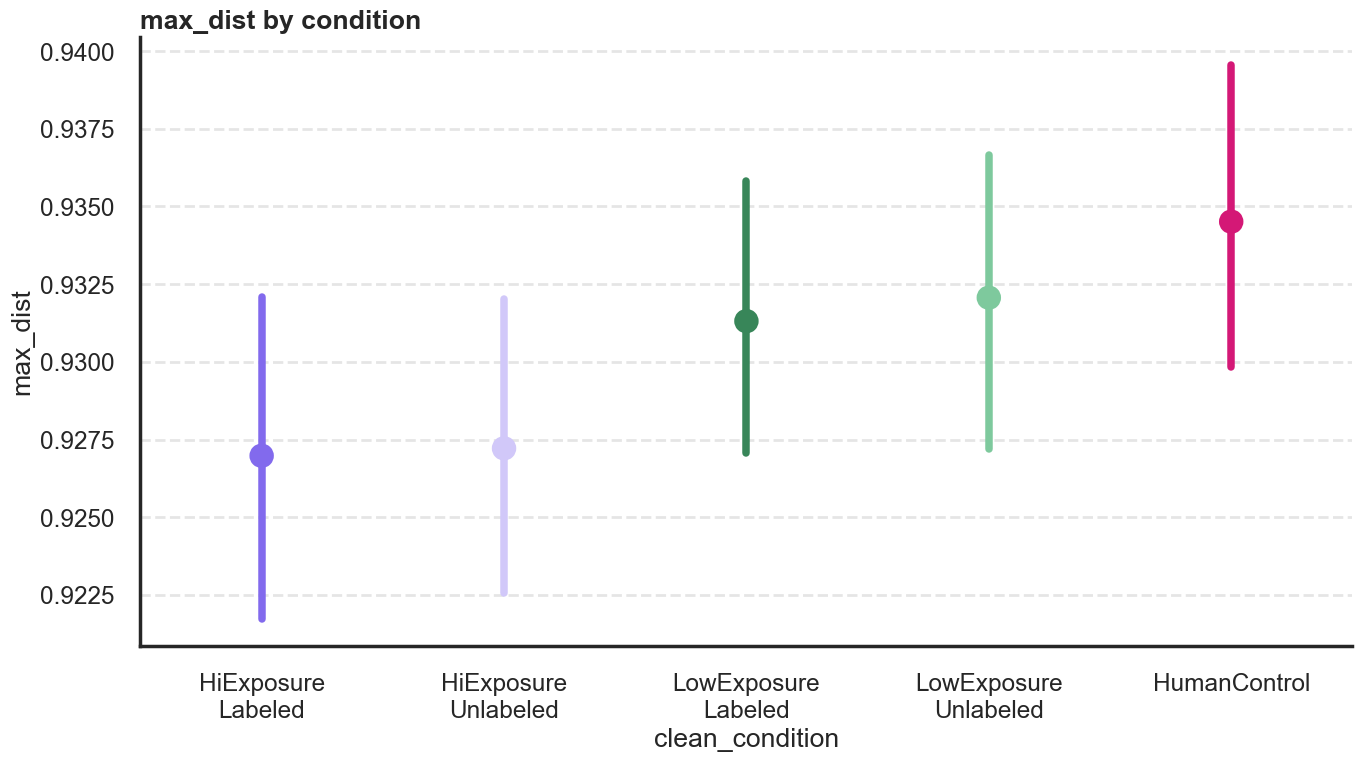

We conducted a Kruskal Wallis test and found human_cent_dist differed by clean_condition, H=266.82, p=1.5431847643083376e-56


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HumanControl,LowExposure\nLabeled,-0.027166,-0.233101,0.000100,0.000143,YES
1,HumanControl,LowExposure\nUnlabeled,-0.023989,-0.205160,0.000300,0.000375,YES
2,HumanControl,HiExposure\nLabeled,-0.081517,-0.706286,0.000100,0.000143,YES
3,HumanControl,HiExposure\nUnlabeled,-0.084928,-0.718227,0.000100,0.000143,YES
4,LowExposure\nLabeled,LowExposure\nUnlabeled,0.003177,0.027987,0.614439,0.614439,NO
5,LowExposure\nLabeled,HiExposure\nLabeled,-0.054351,-0.485464,0.000100,0.000143,YES
6,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.057762,-0.502836,0.000100,0.000143,YES
7,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.057528,-0.511999,0.000100,0.000143,YES
8,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.060939,-0.528685,0.000100,0.000143,YES
9,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.003411,-0.029989,0.583742,0.614439,NO


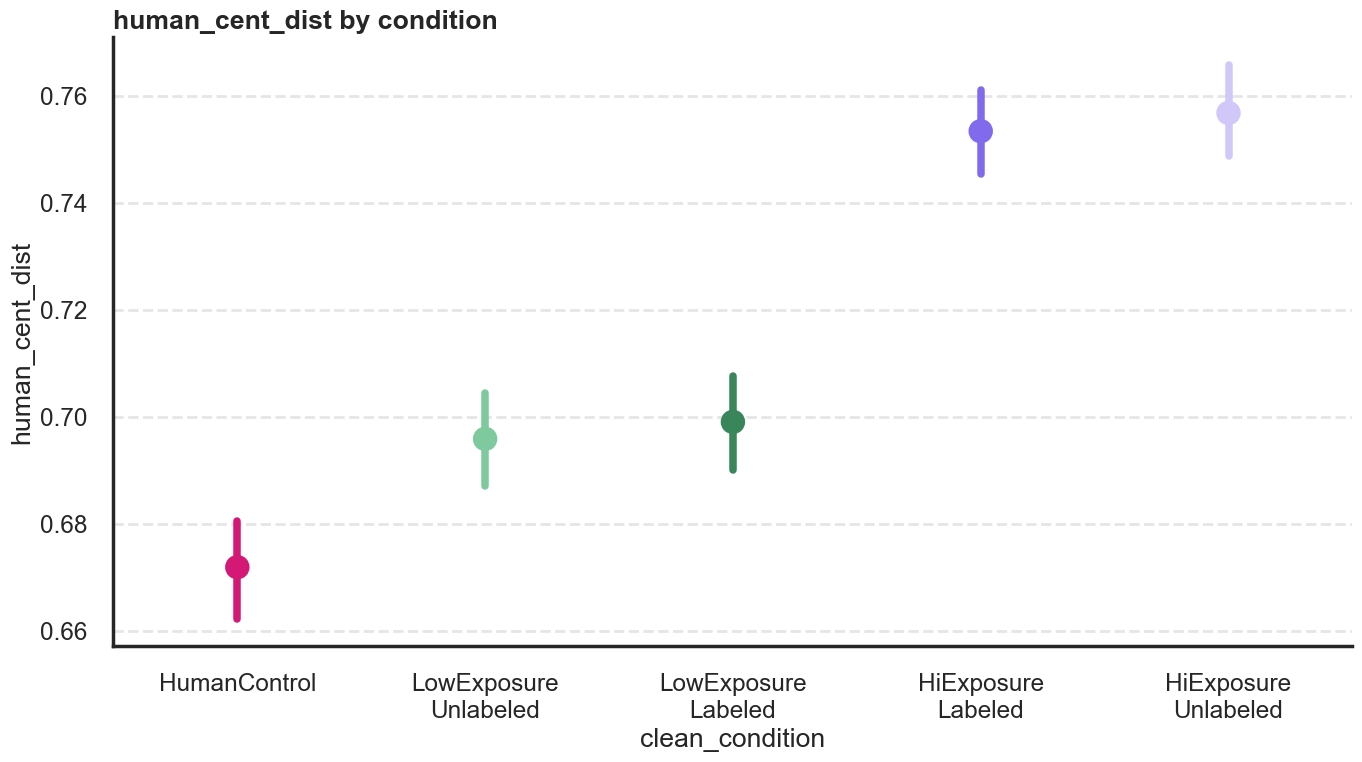

We conducted a Kruskal Wallis test and found ai_cent_dist differed by clean_condition, H=74.11, p=5.615290498476831e-16


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.010427,-0.089276,0.103590,0.124308,NO
1,LowExposure\nLabeled,HiExposure\nLabeled,0.031980,0.268720,0.000100,0.000150,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,0.039801,0.323804,0.000100,0.000150,YES
3,LowExposure\nUnlabeled,HiExposure\nLabeled,0.042407,0.354793,0.000100,0.000150,YES
4,LowExposure\nUnlabeled,HiExposure\nUnlabeled,0.050229,0.406973,0.000100,0.000150,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,0.007822,0.062317,0.252075,0.252075,NO


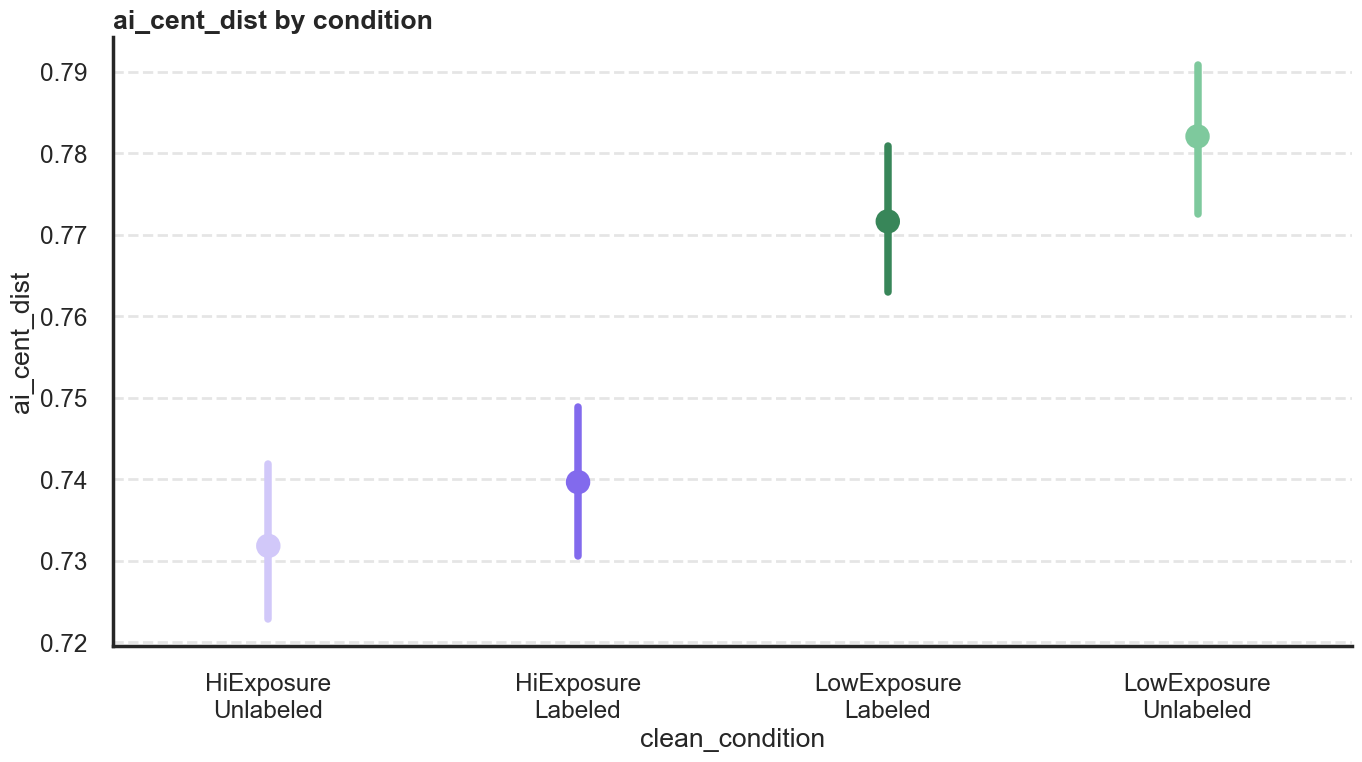

We conducted a Kruskal Wallis test and found ai_human_ratio_sim DID NOT DIFFER by clean_condition, H=6.72, p=0.0814799049360125


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,LowExposure\nLabeled,LowExposure\nUnlabeled,0.010974,0.110551,0.043196,0.129587,NO
1,LowExposure\nLabeled,HiExposure\nLabeled,0.005289,0.053671,0.319468,0.383362,NO
2,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.002030,-0.019441,0.717328,0.717328,NO
3,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.005685,-0.057470,0.282772,0.383362,NO
4,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.013004,-0.124127,0.022098,0.129587,NO
5,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.007319,-0.070320,0.188481,0.376962,NO


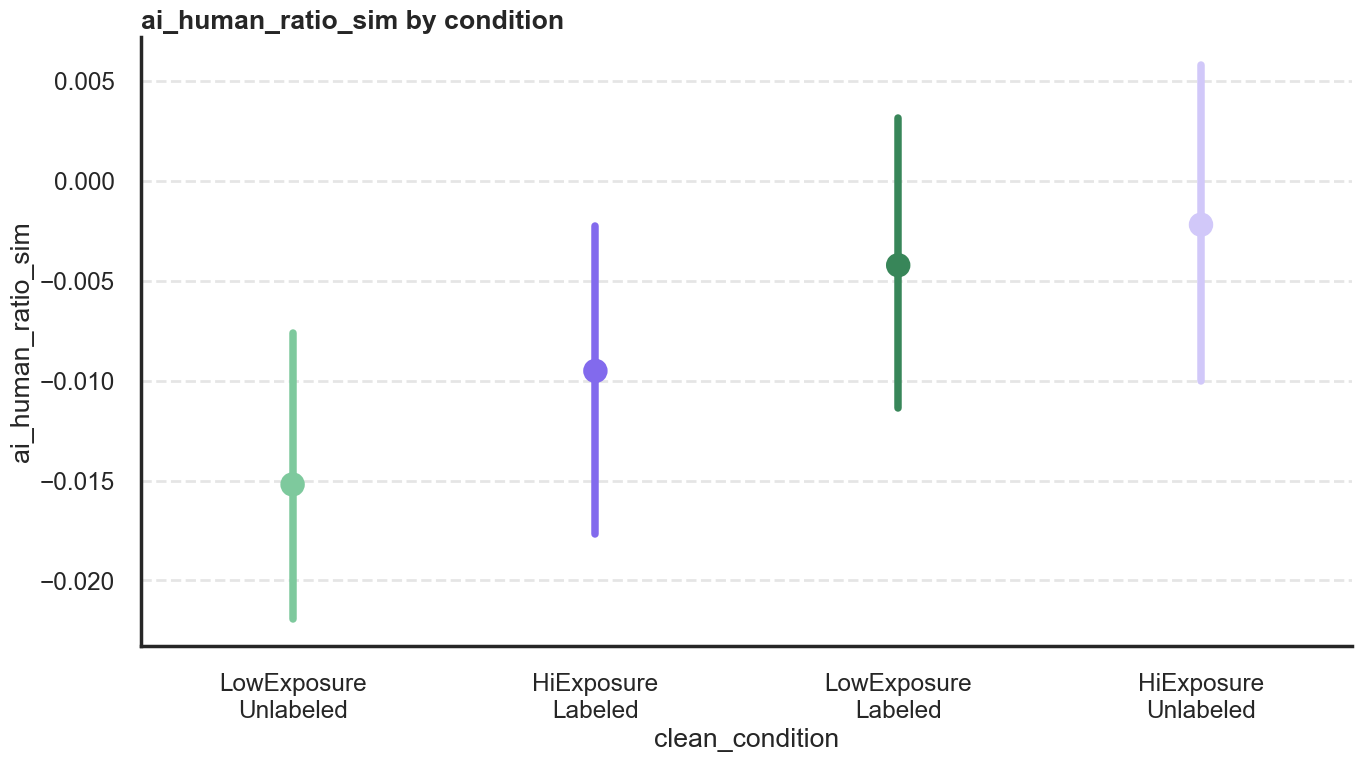

We conducted a Kruskal Wallis test and found ai_max_sim differed by clean_condition, H=100.86, p=1.0156623334715193e-21


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,LowExposure\nLabeled,LowExposure\nUnlabeled,0.007676,0.065843,0.225677,0.270813,NO
1,LowExposure\nLabeled,HiExposure\nLabeled,-0.038967,-0.331463,0.000100,0.000150,YES
2,LowExposure\nLabeled,HiExposure\nUnlabeled,-0.046100,-0.380029,0.000100,0.000150,YES
3,LowExposure\nUnlabeled,HiExposure\nLabeled,-0.046643,-0.395538,0.000100,0.000150,YES
4,LowExposure\nUnlabeled,HiExposure\nUnlabeled,-0.053775,-0.442027,0.000100,0.000150,YES
5,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.007132,-0.058175,0.286471,0.286471,NO


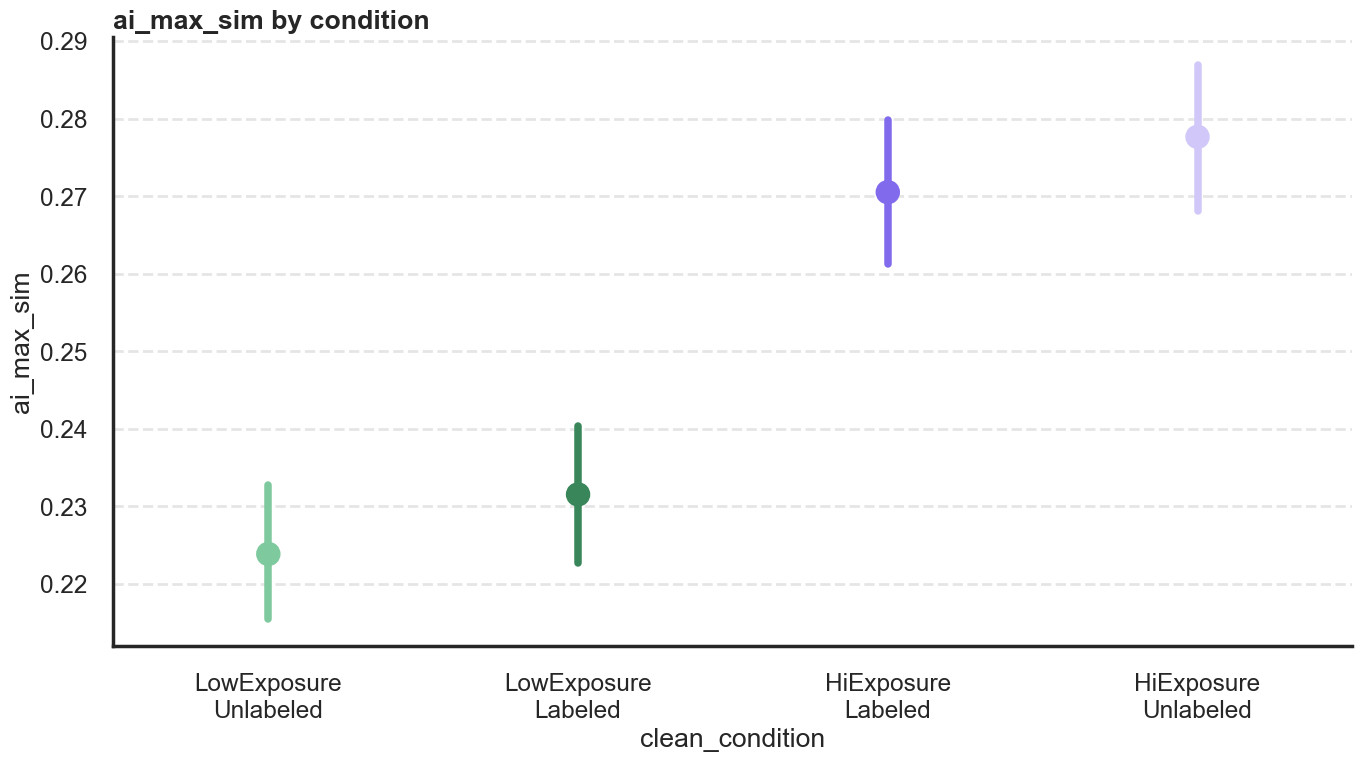

In [290]:
def local_semantic_measures(row, idea2vec):
    # I want to make sure no centroid similarities are confounded by the fact that the compositon of centroid is larger.
    # So a simple way around this is just to randomly sample 2 human ideas and 2 AI ideas and create centroids from those --
    # that way no condition has larger AI or Human centroids. If anything this biases results DOWNARDS.
    example_list = row['init_array_list']
    example_rids = row['init_array']
    idea_vec = idea2vec[row['response_text']]

    ai_ideas = [
        example_list[i] for i in range(len(example_list))
        if "ai" in example_rids[i].lower()
    ]
    example_vecs = [idea2vec[example] for example in example_list]
    ai_example_vecs = [idea2vec[example] for example in ai_ideas]
    human_example_vecs = [
        idea2vec[example] for example in example_list
        if example not in ai_ideas
    ]

    distances_to_examples = cdist([idea_vec], example_vecs, metric='cosine')
    distances_to_human_examples = cdist([idea_vec],
                                        human_example_vecs,
                                        metric='cosine')

    # distance between idea_vec and centroid of example_vecs
    centroid = np.mean(example_vecs, axis=0)
    human_centroid = np.mean(human_example_vecs, axis=0)
    cent_dist = cdist([idea_vec], [centroid], metric='cosine')[0][0]
    human_cent_dist = cdist([idea_vec], [human_centroid],
                            metric='cosine')[0][0]
   
    # For the human condition, there are no ai ideas
    # so we replace metrics with nan if human
    if ai_example_vecs:
        distances_to_ai_examples = cdist([idea_vec],
                                         ai_example_vecs,
                                         metric='cosine')

        ai_centroid = np.mean(ai_example_vecs, axis=0)
        ai_cent_dist = cdist([idea_vec], [ai_centroid], metric='cosine')[0][0]
        ai_max_sim = 1 - np.min(distances_to_ai_examples)

    else:
        distances_to_ai_examples = np.NaN
        ai_cent_dist = np.NaN
        ai_max_sim = np.NaN

    return pd.Series({
        'cent_dist': cent_dist,
        'max_sim': 1 - np.min(distances_to_examples),
        'max_dist': np.max(distances_to_examples),
        'human_cent_dist': human_cent_dist,
        'ai_cent_dist': ai_cent_dist,
        'ai_human_ratio_sim': (1-np.mean(distances_to_ai_examples)) - (1-np.mean(distances_to_human_examples)),
        'ai_max_sim': ai_max_sim
    })


df = df.query("exclude_from_analysis==0")
semantic_measures_df = df.apply(lambda row: local_semantic_measures(row, idea2vec), axis=1)
df = pd.concat([df, semantic_measures_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.to_csv("../../data/experiment_data/data_clean_with_elab_div_metrics.csv")
process_metrics(df)

# GLOBAL DIVERSITY

## Number of distinct topics
The idea is to: 
1. Make an undirected graph from semantic similarities between ideas
2. Partition this graph 
3. Count partitions as a proxy for 'distinct ideas'

Explanation for level
- I realized that doing this at the response chain level is too low since you can't really build a semantic map with 20 ideas.
- Doing this at the condition level is good but results are confounded by different items
- Doing this at the condition X item level makes the most sense

Explanation for monte carlo proceedure:
- I did not want to have my results depend on the specific seed I picked or specific resolution, so I run the algo many times


So I create partitions at the (condition, item) level but bootstrap to get more data, then permutation test on the bootstrapped data.

['number_concepts_per_item_dist', 'modularity_dist']
We conducted a Kruskal Wallis test and found number_concepts_per_item_dist differed by clean_condition, H=149.33, p=2.8316364515068196e-31


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.056,-0.044865,0.326239,0.326239,NO
1,HiExposure\nLabeled,HumanControl,0.133,0.111769,0.012998,0.016248,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,-0.548,-0.442568,0.000143,0.000286,YES
3,HiExposure\nLabeled,LowExposure\nUnlabeled,-0.188,-0.155035,0.000429,0.000714,YES
4,HiExposure\nUnlabeled,HumanControl,0.189,0.154937,0.000714,0.001020,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,-0.492,-0.388324,0.000143,0.000286,YES
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,-0.132,-0.106282,0.018854,0.020949,YES
7,HumanControl,LowExposure\nLabeled,-0.681,-0.562969,0.000143,0.000286,YES
8,HumanControl,LowExposure\nUnlabeled,-0.321,-0.271243,0.000143,0.000286,YES
9,LowExposure\nLabeled,LowExposure\nUnlabeled,0.360,0.292215,0.000143,0.000286,YES


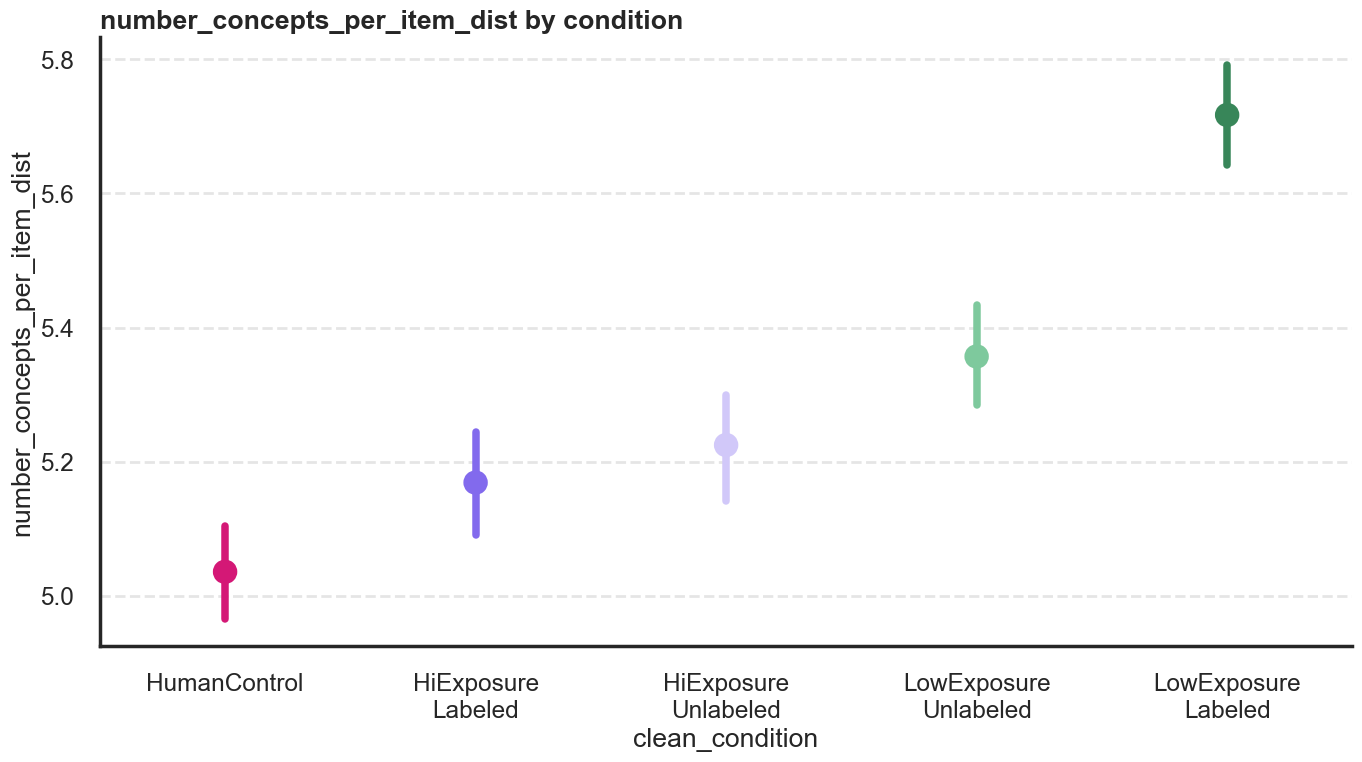

We conducted a Kruskal Wallis test and found modularity_dist differed by clean_condition, H=386.98, p=1.8062089430179466e-82


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.003702,-0.264553,0.000143,0.000179,YES
1,HiExposure\nLabeled,HumanControl,-0.001564,-0.107829,0.017569,0.017569,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,0.007877,0.559303,0.000143,0.000179,YES
3,HiExposure\nLabeled,LowExposure\nUnlabeled,0.002097,0.119024,0.007856,0.008729,YES
4,HiExposure\nUnlabeled,HumanControl,0.002138,0.163741,0.000143,0.000179,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,0.011579,0.919299,0.000143,0.000179,YES
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.005799,0.352478,0.000143,0.000179,YES
7,HumanControl,LowExposure\nLabeled,0.009441,0.717561,0.000143,0.000179,YES
8,HumanControl,LowExposure\nUnlabeled,0.003660,0.216785,0.000143,0.000179,YES
9,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.005780,-0.349712,0.000143,0.000179,YES


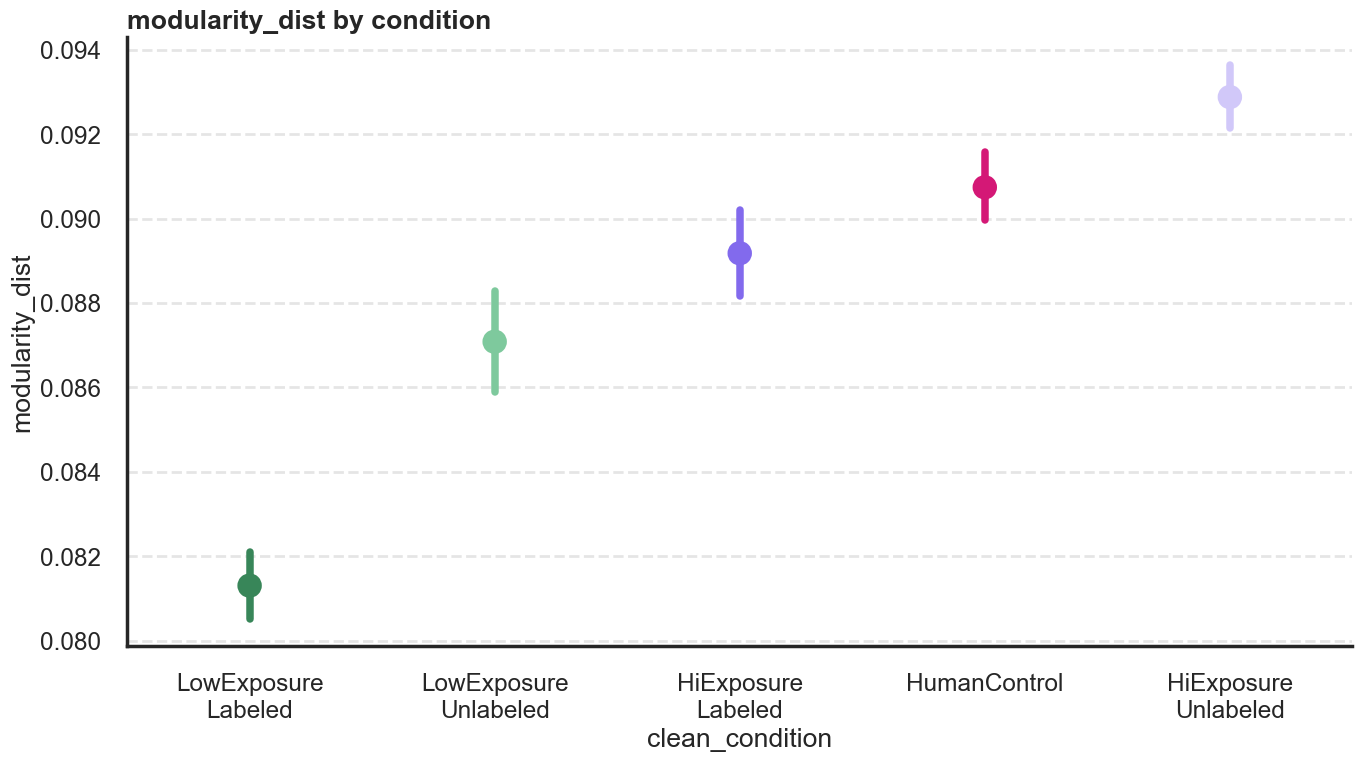

In [490]:
from networkx.algorithms.community.quality import modularity

def from_numpy_matrix(A):
    G = nx.Graph()
    for i in range(A.shape[0]):
        for j in range(i, A.shape[1]):
            G.add_edge(i, j, weight=A[i, j])
    return G

def get_communities(list_vecs, seed, resolution):
    sim_mat = cosine_similarity(list_vecs)
    G = from_numpy_matrix(sim_mat)
    G.remove_edges_from(nx.selfloop_edges(G))
    partition = nx.community.louvain_communities(
        G, seed=seed, resolution=resolution)
    modularity_val = modularity(G, partition)
    
    return len(partition), modularity_val


def get_communities_mc(df, seed):
    np.random.seed(seed)  # set seed for reproducibility
    resolution = np.random.choice([1, 1.05, 1.10])  # choose a random number of splits
    condition_ideas = df.groupby(
        by=['clean_condition', 'condition', 'item'])['response_text'].apply(
            lambda x: list(x)).reset_index()
    condition_ideas['vectors'] = condition_ideas['response_text'].apply(
        lambda x: np.vstack([idea2vec[i] for i in x]))
    condition_ideas['number_concepts_per_item_dist'], condition_ideas['modularity_dist'] = zip(*condition_ideas[
        'vectors'].apply(lambda x: get_communities(x, seed, resolution)))
    condition_ideas['iteration'] = seed
    condition_ideas['resolution'] = resolution
    condition_ideas['key'] = 'seed' + condition_ideas['iteration'].astype(str) + '_resolution' + condition_ideas['resolution'].astype(str)
    return condition_ideas[[
        'clean_condition', 'item', 'number_concepts_per_item_dist', 'modularity_dist', 'iteration', 'resolution', 'key'
    ]]

n_iterations = 200
mc_results = Parallel(n_jobs=-1)(delayed(get_communities_mc)(df, i)
                                 for i in range(n_iterations))
mc_results = pd.concat(mc_results)
process_metrics(mc_results, num_perm=7000)

## PCA Variance By Fold

In this version, I do the following:

1. Randomly split the set of idea vectors in half. 
2. Fit PCA on the first half.
3. See how well the first component can explain the 2nd half 

['pc_fold_dist']
We conducted a Kruskal Wallis test and found pc_fold_dist differed by clean_condition, H=426.02, p=6.630724882127953e-91


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.001228,-0.178911,0.004100,0.004555,YES
1,HiExposure\nLabeled,HumanControl,-0.003515,-0.447240,0.000100,0.000125,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,0.005811,0.946230,0.000100,0.000125,YES
3,HiExposure\nLabeled,LowExposure\nUnlabeled,0.000551,0.077052,0.226077,0.226077,NO
4,HiExposure\nUnlabeled,HumanControl,-0.002287,-0.302673,0.000100,0.000125,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,0.007039,1.224609,0.000100,0.000125,YES
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.001779,0.261162,0.000100,0.000125,YES
7,HumanControl,LowExposure\nLabeled,0.009326,1.350392,0.000100,0.000125,YES
8,HumanControl,LowExposure\nUnlabeled,0.004065,0.520388,0.000100,0.000125,YES
9,LowExposure\nLabeled,LowExposure\nUnlabeled,-0.005261,-0.865024,0.000100,0.000125,YES


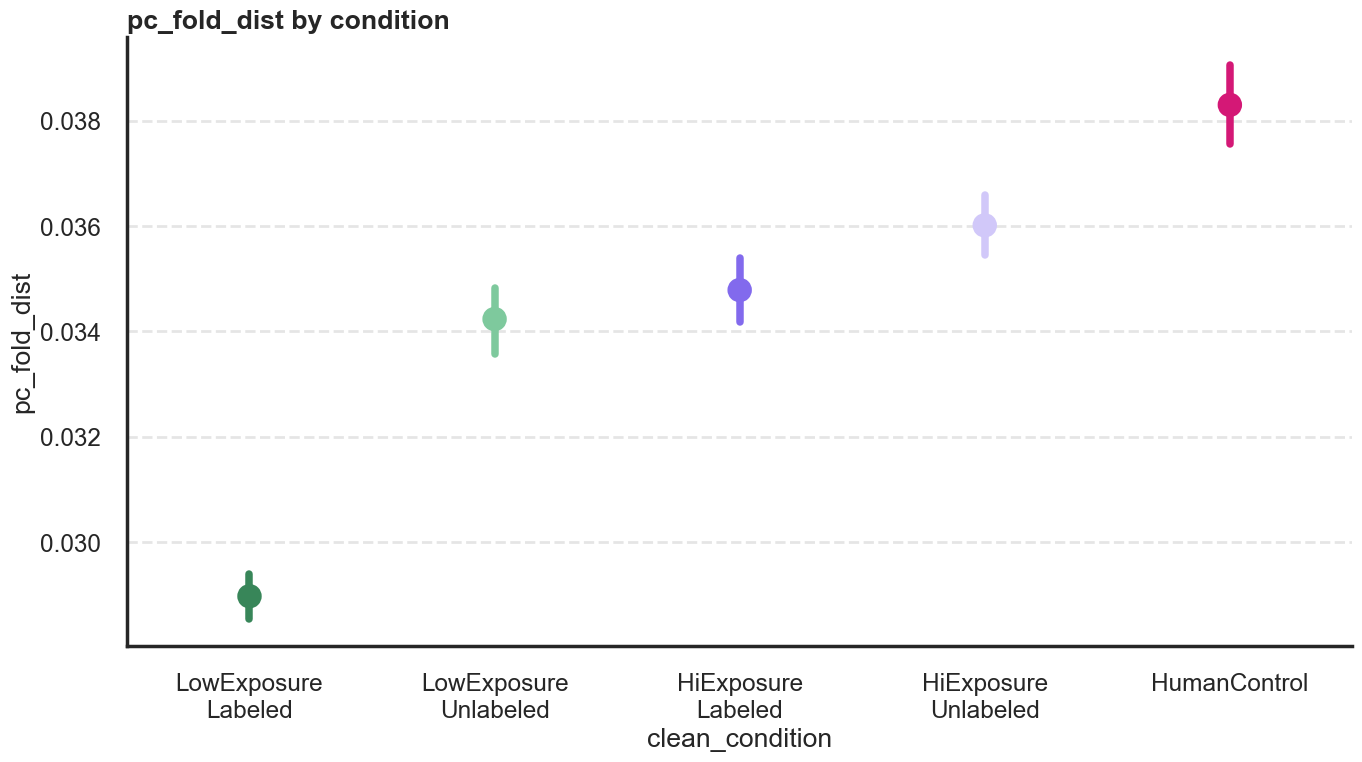

In [586]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

def calculate_pca_variance(vecs, seed):
    vec_df = pd.DataFrame(vecs)
    train_df, test_df = train_test_split(vec_df, test_size=0.5, random_state=seed)
    pca = PCA(n_components=1, random_state=seed)  # Set random_state for PCA initialization
    pca.fit(train_df)
    test_df_transformed = pca.transform(test_df)
    explained_variance = np.var(test_df_transformed, axis=0)[0]
    return explained_variance


def process_iteration(tdf, seed):
    np.random.seed(seed)  # set seed for reproducibility
    condition_ideas = tdf.groupby(by=['clean_condition', 'condition', 'item'])['response_text'].apply(lambda x: list(x)).reset_index()
    condition_ideas['vectors'] = condition_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
    condition_ideas['pc_fold_dist'] = condition_ideas['vectors'].apply(lambda x: calculate_pca_variance(x, seed))
    condition_ideas['seed'] = seed
    return condition_ideas

# Run the iterations in parallel using joblib
pca_results = Parallel(n_jobs=-1)(delayed(process_iteration)(df, i) for i in range(100))
pca_df = pd.concat(pca_results)
process_metrics(pca_df)

## Lexical Diversity

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jashkina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['mattr_ttr_dist', 'mtld_dist', 'shannon_e_dist']
We conducted a Kruskal Wallis test and found mattr_ttr_dist differed by clean_condition, H=69.36, p=3.105051441100568e-14


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.001013,-0.378200,0.000100,0.000250,YES
1,HiExposure\nLabeled,HumanControl,-0.000524,-0.202339,0.020798,0.029711,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,-0.000908,-0.320206,0.000300,0.000600,YES
3,HiExposure\nLabeled,LowExposure\nUnlabeled,0.000843,0.322420,0.000400,0.000667,YES
4,HiExposure\nUnlabeled,HumanControl,0.000489,0.183513,0.039696,0.049620,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,0.000105,0.036053,0.687131,0.687131,NO
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.001856,0.690730,0.000100,0.000250,YES
7,HumanControl,LowExposure\nLabeled,-0.000384,-0.136088,0.125287,0.139208,NO
8,HumanControl,LowExposure\nUnlabeled,0.001367,0.525952,0.000100,0.000250,YES
9,LowExposure\nLabeled,LowExposure\nUnlabeled,0.001751,0.615641,0.000100,0.000250,YES


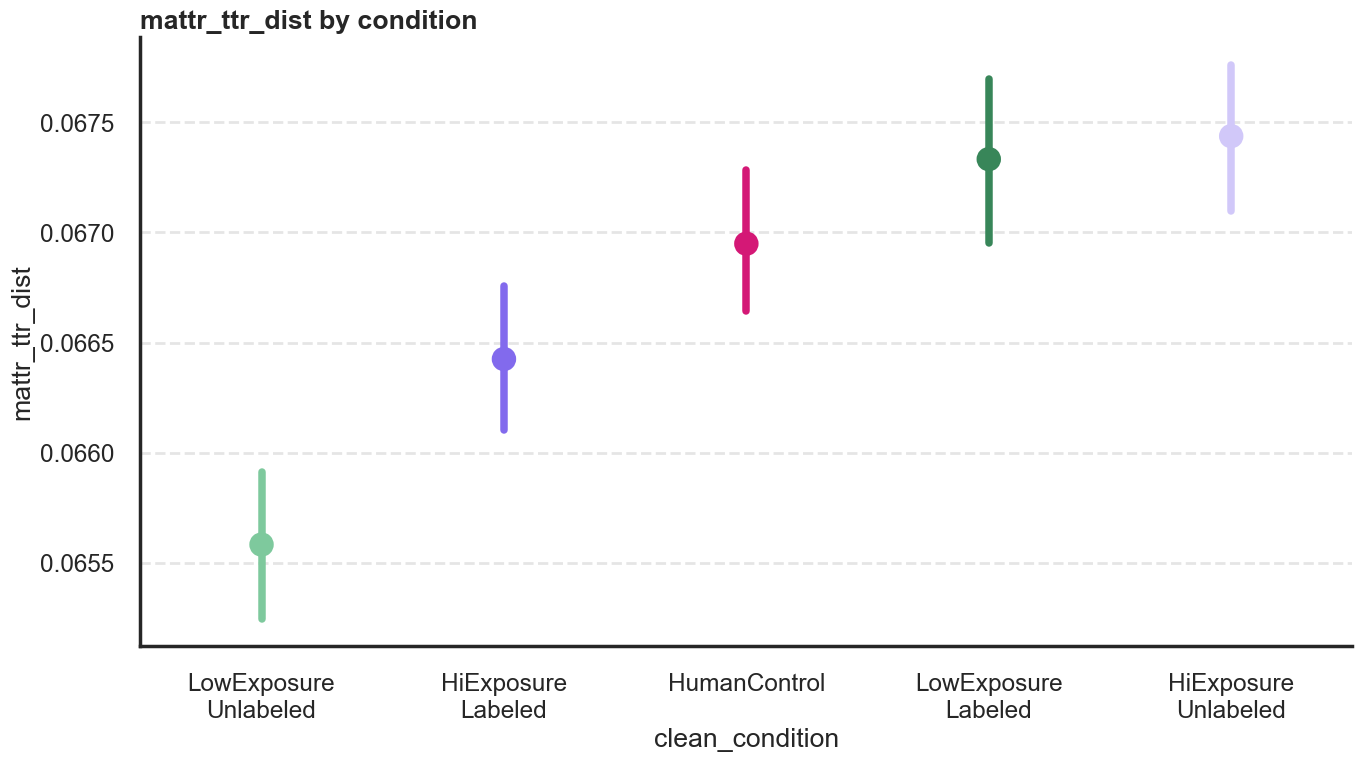

We conducted a Kruskal Wallis test and found mtld_dist differed by clean_condition, H=25.89, p=3.3296284973070574e-05


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,0.049633,0.168886,0.061294,0.104823,NO
1,HiExposure\nLabeled,HumanControl,0.070914,0.236236,0.007999,0.019998,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,-0.042605,-0.144292,0.107489,0.153556,NO
3,HiExposure\nLabeled,LowExposure\nUnlabeled,0.051369,0.169014,0.062894,0.104823,NO
4,HiExposure\nUnlabeled,HumanControl,0.021281,0.080760,0.364764,0.455954,NO
5,HiExposure\nUnlabeled,LowExposure\nLabeled,-0.092238,-0.357657,0.000100,0.000500,YES
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.001735,0.006481,0.945905,0.945905,NO
7,HumanControl,LowExposure\nLabeled,-0.113519,-0.428293,0.000100,0.000500,YES
8,HumanControl,LowExposure\nUnlabeled,-0.019546,-0.071161,0.437056,0.485618,NO
9,LowExposure\nLabeled,LowExposure\nUnlabeled,0.093973,0.348973,0.000200,0.000667,YES


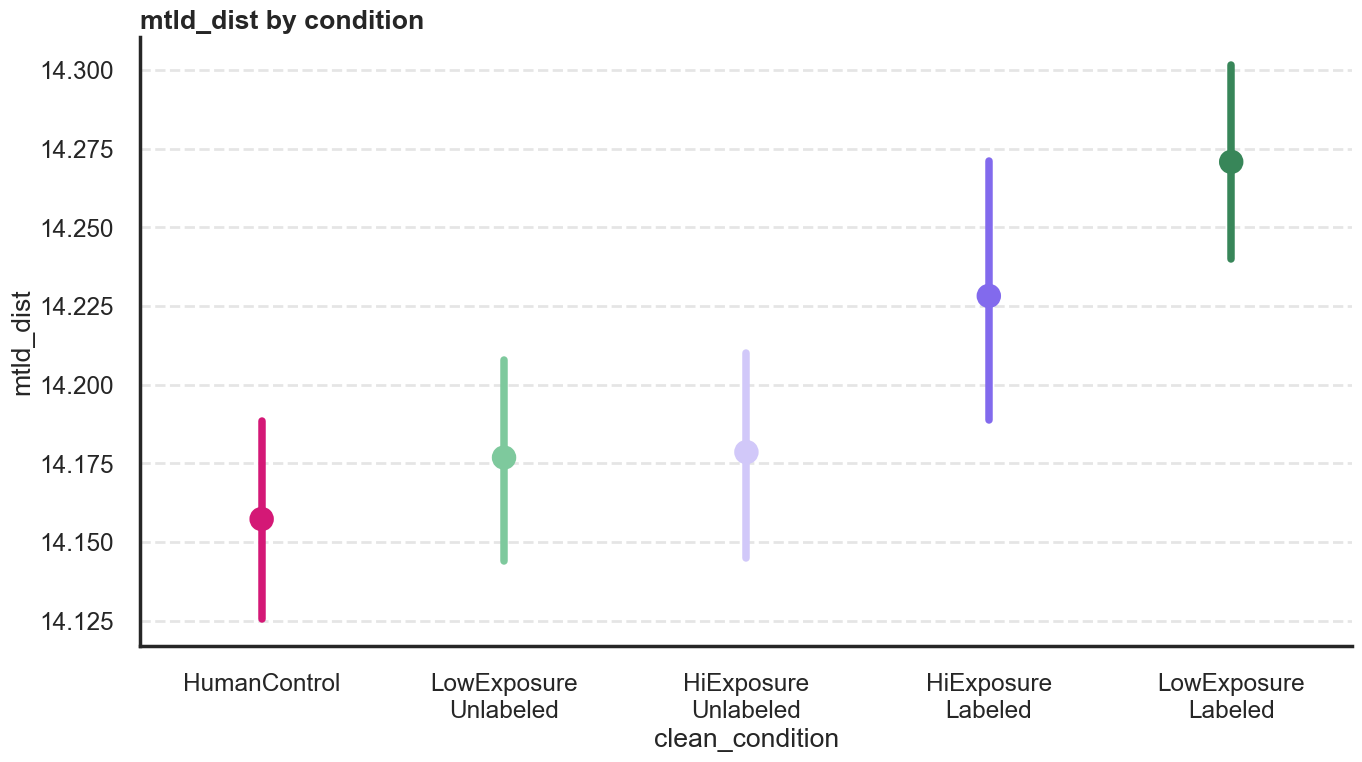

We conducted a Kruskal Wallis test and found shannon_e_dist differed by clean_condition, H=176.04, p=5.2819565063721535e-37


,group1,group2,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,-0.013267,-0.705543,0.000100,0.000167,YES
1,HiExposure\nLabeled,HumanControl,-0.012130,-0.669191,0.000100,0.000167,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,-0.015766,-0.970300,0.000100,0.000167,YES
3,HiExposure\nLabeled,LowExposure\nUnlabeled,0.001199,0.071572,0.423958,0.471064,NO
4,HiExposure\nUnlabeled,HumanControl,0.001137,0.057051,0.512849,0.512849,NO
5,HiExposure\nUnlabeled,LowExposure\nLabeled,-0.002499,-0.137013,0.126187,0.157734,NO
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.014466,0.774084,0.000100,0.000167,YES
7,HumanControl,LowExposure\nLabeled,-0.003636,-0.207304,0.017698,0.025283,YES
8,HumanControl,LowExposure\nUnlabeled,0.013329,0.740256,0.000100,0.000167,YES
9,LowExposure\nLabeled,LowExposure\nUnlabeled,0.016965,1.052805,0.000100,0.000167,YES


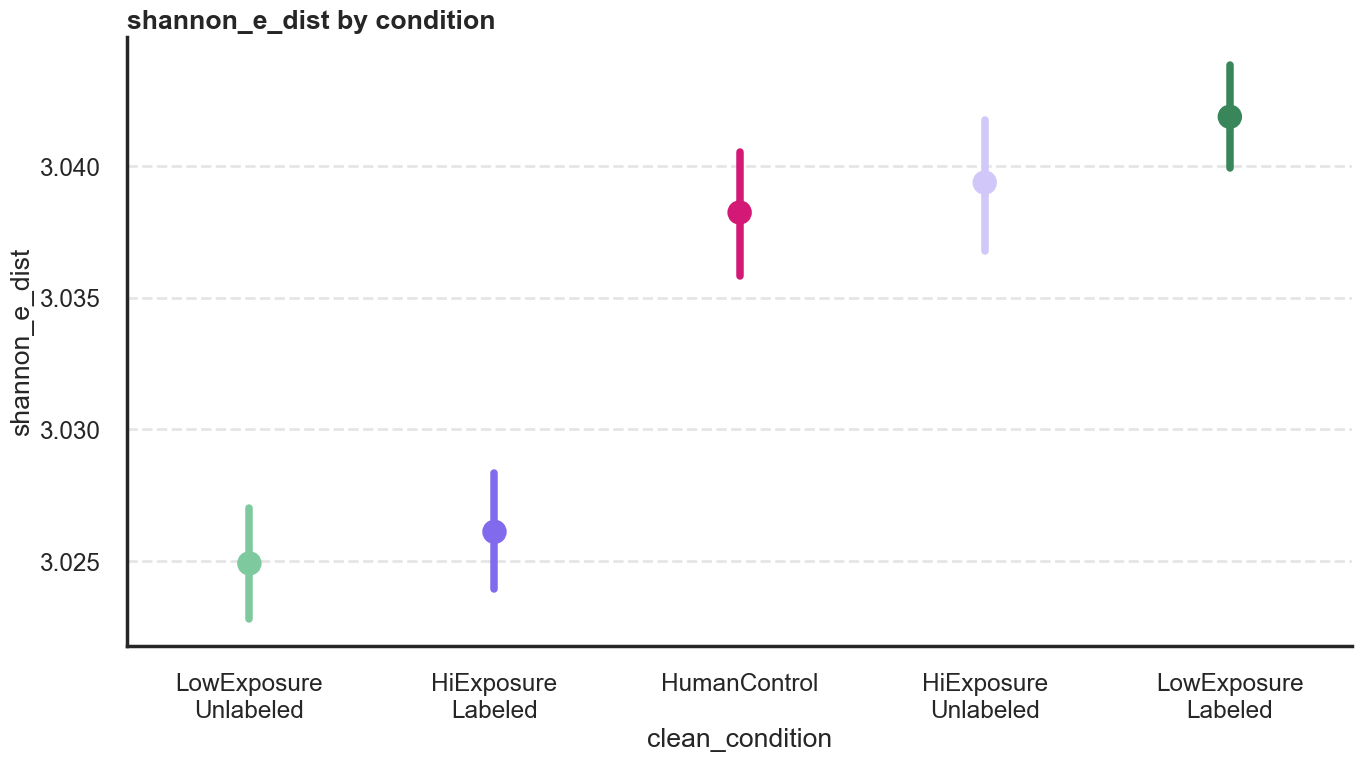

In [587]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
from nltk.util import ngrams
from lexical_diversity import lex_div as ld
from collections import Counter
from scipy.stats import entropy
import numpy as np
from nltk import word_tokenize, pos_tag, ngrams
import pandas as pd
from collections import Counter
from scipy.stats import entropy
import numpy as np
from nltk import word_tokenize, pos_tag, ngrams
import pandas as pd

nltk.download('averaged_perceptron_tagger')

def compute_lexical_diversity(docs, mw):
    tokens = [word for doc in docs for word in word_tokenize(doc)]
    types = set(tokens)
    word_counts = Counter(tokens)

    return pd.Series({
        'mattr_ttr_dist':  ld.mattr(tokens, window_length= mw),
        'mtld_dist': ld.mtld(tokens),
        'shannon_e_dist': entropy(list(word_counts.values())),
    })
    

def process_iteration(tdf, seed):
    np.random.seed(seed)  # set seed for reproducibility
    tdf_sampled = tdf[['clean_condition', 'condition', 'response_text', 'item']].sample(frac=0.5, random_state=seed)
    tdf_sampled = tdf_sampled.groupby(['clean_condition', 'condition', 'item'])['response_text'].apply(lambda x: "".join(x)).reset_index()
    mean_len = int(np.mean([len(word_tokenize(x)) for x in tdf_sampled['response_text']]))
    lexical_diversity = tdf_sampled['response_text'].apply(lambda x: compute_lexical_diversity(x, mean_len))
    condition_ideas = pd.concat([tdf_sampled, lexical_diversity], axis=1).reset_index(drop=True)
    return condition_ideas
    
div_results = Parallel(n_jobs=-1)(delayed(process_iteration)(df, i) for i in range(50))
div_df = pd.concat(div_results)

vars_to_rank = [x for x in div_df.columns if "dist" in x]
melted_df = pd.melt(div_df, id_vars=['clean_condition', 'condition'], 
                    value_vars=vars_to_rank, var_name='var', value_name='value')
process_metrics(div_df, plot_type='point')